In [1]:
import torch
import gpytorch
import math
from matplotlib import pyplot as plt
import numpy as np

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
lb, ub = 0.0, 5*math.pi
n = 100

train_x = torch.linspace(lb, ub, n).unsqueeze(-1) + 0.01*torch.randn(n, 1)
train_y = torch.stack([
    torch.sin(2*train_x) + torch.cos(train_x), 
    -torch.sin(train_x) + 2*torch.cos(2*train_x)
], -1).squeeze(1)

train_y += 0.05 * torch.randn(n, 2)

In [3]:
class GPModelWithDerivatives(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModelWithDerivatives, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMeanGrad()
        self.base_kernel = gpytorch.kernels.RBFKernelGrad()
        self.covar_module =gpytorch.kernels.RBFKernelGrad()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
likelihood.initialize(noise=0.01)
likelihood.raw_noise.requires_grad = False
model = GPModelWithDerivatives(train_x, train_y, likelihood)

In [4]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

with gpytorch.settings.max_preconditioner_size(20), gpytorch.settings.max_cg_iterations(50):
    n_iter = 50
    for i in range(n_iter):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f   log_lengthscale: %.3f   log_noise: %.3f' % (
            i + 1, n_iter, loss.item(),
            model.covar_module.lengthscale.item(),
            model.likelihood.log_noise.item()
        ))        
        optimizer.step()

Iter 1/50 - Loss: 119.235   log_lengthscale: 0.693   log_noise: -4.605
Iter 2/50 - Loss: 113.814   log_lengthscale: 0.744   log_noise: -4.605
Iter 3/50 - Loss: 109.178   log_lengthscale: 0.796   log_noise: -4.605
Iter 4/50 - Loss: 104.745   log_lengthscale: 0.850   log_noise: -4.605
Iter 5/50 - Loss: 100.758   log_lengthscale: 0.903   log_noise: -4.605
Iter 6/50 - Loss: 96.835   log_lengthscale: 0.955   log_noise: -4.605
Iter 7/50 - Loss: 93.260   log_lengthscale: 1.003   log_noise: -4.605
Iter 8/50 - Loss: 89.637   log_lengthscale: 1.039   log_noise: -4.605
Iter 9/50 - Loss: 85.894   log_lengthscale: 1.064   log_noise: -4.605
Iter 10/50 - Loss: 81.914   log_lengthscale: 1.076   log_noise: -4.605
Iter 11/50 - Loss: 77.104   log_lengthscale: 1.075   log_noise: -4.605
Iter 12/50 - Loss: 72.943   log_lengthscale: 1.062   log_noise: -4.605
Iter 13/50 - Loss: 68.337   log_lengthscale: 1.041   log_noise: -4.605
Iter 14/50 - Loss: 63.714   log_lengthscale: 1.015   log_noise: -4.605
Iter 15/50

## Predicting 

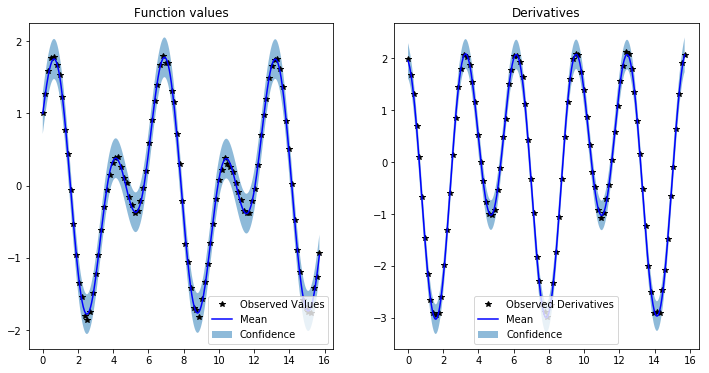

In [5]:
# Set into eval mode
model.train()
model.eval()
likelihood.eval()

# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(12, 6))

# Make predictions
with torch.no_grad(), gpytorch.settings.max_preconditioner_size(20), gpytorch.settings.max_cg_iterations(50):
    test_x = torch.linspace(lb, ub, 500)
    predictions = likelihood(model(test_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()
    
# Plot training data as black stars
y1_ax.plot(train_x.detach().numpy(), train_y[:, 0].detach().numpy(), 'k*')
# Predictive mean as blue line
y1_ax.plot(test_x.numpy(), mean[:, 0].numpy(), 'b')
# Shade in confidence 
y1_ax.fill_between(test_x.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
y1_ax.legend(['Observed Values', 'Mean', 'Confidence'])
y1_ax.set_title('Function values')

# Plot training data as black stars
y2_ax.plot(train_x.detach().numpy(), train_y[:, 1].detach().numpy(), 'k*')
# Predictive mean as blue line
y2_ax.plot(test_x.numpy(), mean[:, 1].numpy(), 'b')
# Shade in confidence 
y2_ax.fill_between(test_x.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
y2_ax.legend(['Observed Derivatives', 'Mean', 'Confidence'])
y2_ax.set_title('Derivatives')

None

In [6]:
model.likelihood.noise

tensor([[0.0100]])

In [7]:
list(model.likelihood.noise_covar.noise)

[tensor([0.0077, 0.0078], grad_fn=<SelectBackward>)]